# How Has Political Sentiment Changed Over the Course of the Pandemic?

In [1]:
# Just to keep output tidy - remove later
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd

from src.data_processing import *
from src.helpers import *
from src.plots import *

In [2]:
DATA_PATH = "./data/"

## Grouping Countries by Response

We can imagine that countries can be grouped together based on their response to the COVID pandemic.

From `interventions.csv`, we can calculate how long it took for the first measures to be imposed after the first case in the country, and for how long mobility in the country was reduced. Based on these two measures, we can try to find clusters of countries in order to group them.

In [3]:
# Loading data
df_dates = pd.read_csv(DATA_PATH + "interventions.csv", index_col="lang")
# Processing data
df_dates = process_interventions_data(df_dates)

df_dates

,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy,Response time,Reduced mobility
country,,,,,,,,,
de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10,47.0,116.0
dk,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05,14.0,86.0
en,NaT,NaT,NaT,NaT,NaT,2020-03-16,2020-05-21,NaN,66.0
es,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaT,37.0,NaN
fi,2020-01-29,2020-03-21,2020-03-16,2020-03-16,NaT,2020-03-16,2020-05-21,47.0,66.0
fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02,49.0,108.0
it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26,34.0,107.0
jp,2020-01-16,2020-02-13,2020-02-27,2020-02-25,NaT,2020-03-31,2020-06-14,40.0,75.0
kr,2020-01-20,2020-02-20,2020-02-23,NaT,NaT,2020-02-25,2020-04-15,34.0,50.0


We calculate the Silhouette Score for different numbers of clusters in order to find the optimal number of clusters.

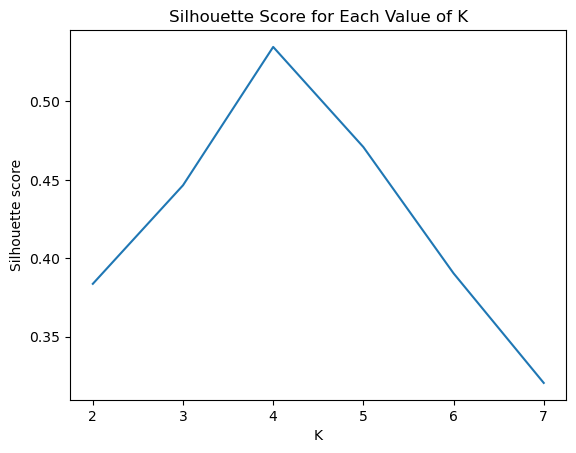

In [4]:
# Select rows where response time and reduced mobility duration are defined
df = df_dates.loc[
    df_dates[["Response time", "Reduced mobility"]].notna().all(1),
    ["Response time", "Reduced mobility"],
]

plot_silhouettes(df, 2, 7)

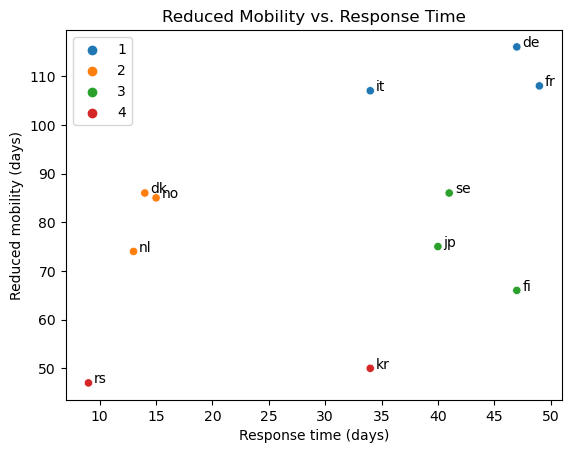

In [5]:
kmeans = KMeans(n_clusters=4, random_state=27).fit(df)

plot_mobility_response(df, kmeans.labels_)

We can identify the following groups of countries:

1. Big European economies which took a long time to react to COVID (possibly due to not wanting to harm the economy or being less able to enforce measures over a large population) and ended up having long periods of reduced mobility (France, Germany, Italy).

2. Smaller highly developed European countries which reacted quickly to COVID and had shorter periods of reduced mobility (Denmark, Netherlands, Norway).

3. Countries which took longer to react to COVID but had shorter periods of reduced mobility (Finland, Japan, Sweden).

4. Countries with relatively short periods of reduced mobility compared to other countries (Serbia, South Korea).

Spain is the only country not featured in the plot above. We take a look at its entry in `interventions.csv`.

In [6]:
# Interventions entry for Spain
df_dates.loc["es"]

1st case                2020-01-31 00:00:00
1st death               2020-02-13 00:00:00
School closure          2020-03-12 00:00:00
Public events banned    2020-03-08 00:00:00
Lockdown                2020-03-14 00:00:00
Mobility                2020-03-16 00:00:00
Normalcy                                NaT
Response time                          37.0
Reduced mobility                        NaN
Name: es, dtype: object

The response time was not swift relative to other countries. The datapoint is not plotted due to having an undefined duration of the reduced mobility period, since there is no date for the return to normal mobility levels. We can say that the reduced mobility period is also a long one, which would place Spain in group 1 - big European economies with a long response time and long period of reduced mobility.

## Obtaining Polling Data

We obtain polling data from [European Opinion Polls as Open Data](https://filipvanlaenen.github.io/eopaod/) - a collection of opinion polls for European countries.

The dataset, understandably, lacks data for Japan and South Korea. Data for Serbia is not present either. Nonetheless, we still have data for 9 of the 12 countries, so we continue working with these countries instead.

Our final groups of countries based on response to the pandemic are:

1. France, Germany, Italy, Spain
2. Denmark, Netherlands, Norway
3. Finland, Sweden

We also have the following geographic groups:

1. Northern Europe - Denmark, Finland, Norway, Sweden
2. Western Europe - France, Germany, Netherlands
3. Southern Europe - Italy, Spain

In [7]:
# Countries grouped by response
response_groups = [
    ["de", "es", "fr", "it"],
    ["dk", "nl", "no"],
    ["fi", "se"],
]

# Countries grouped by geographic region
region_groups = [["dk", "fi", "no", "se"], ["de", "fr", "nl"], ["es", "it"]]

For each country, we plot the polling data for the current 5 most represented parties in parliament (excluding parties founded in 2021 or later). Our error bars represent the standard deviation each month.

In addition, we denote with `*` the main party in government at the beginning of the pandemic and when the first COVID related death occured. This represents the beginning of when the population becomes seriously affected by the virus.

### Group 1

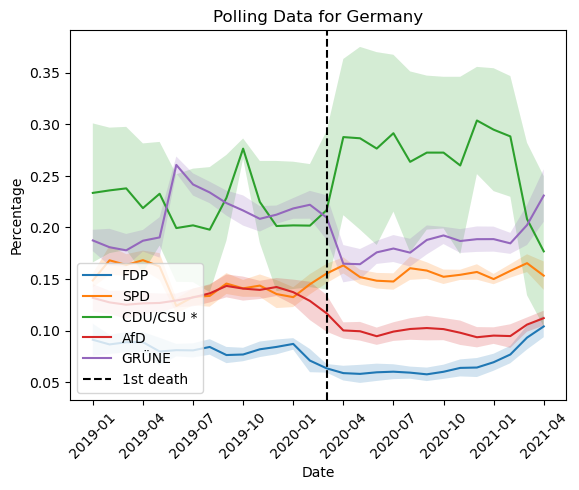

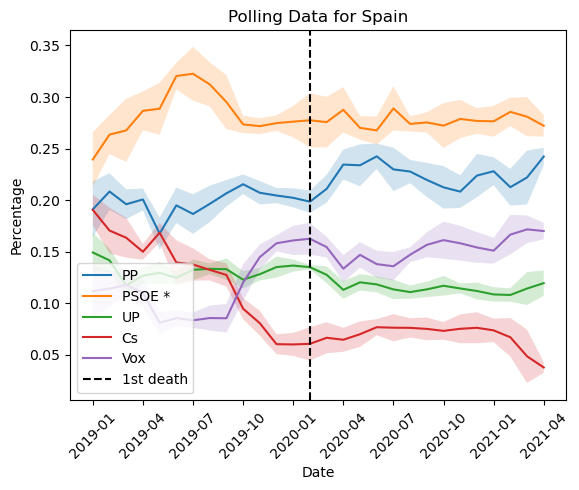

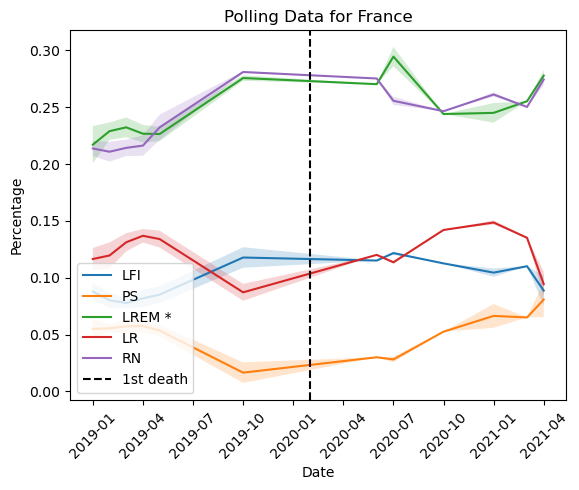

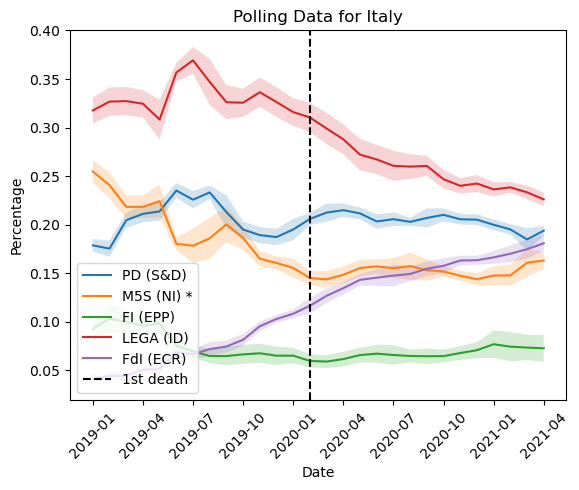

In [8]:
dfs_group1 = []

for country in response_groups[0]:
    df = get_polling_data(country)
    dfs_group1.append(df)
    plot_polling_data(df, country, df_dates)

We observe that for countries in group 1 (large economies), the populations reacted differently. In Germany, a sharp rise in popularity for the ruling party was observed, indicating support for stability and implementating sanitary measures. In Spain, it is the main opposition party which sees a rise in popularity. In Italy, we observe a continual decrease in support for the main party in government which began before the pandemic itself, indicating domestic issues were more influencial than the pandemic for the party's popularity.


We can also plot the polling data for the 5 differents potical alignement, à savoir la gauche, le centre gauche, le centre, le centre droite et la droite. Ici le trait dashé en noir représente the latest first death case over the countries

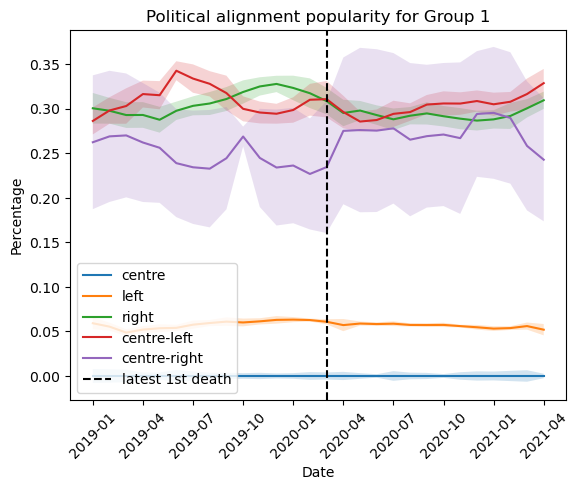

In [9]:
plot_group_alignments(dfs_group1, response_groups[0], df_dates, 'Group 1')

In [ ]:
# Here we can see that the political orientation for group 1 remains stable over time, 


### Group 2

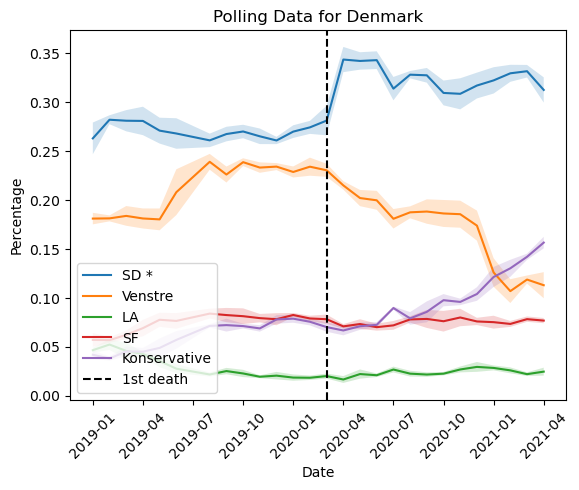

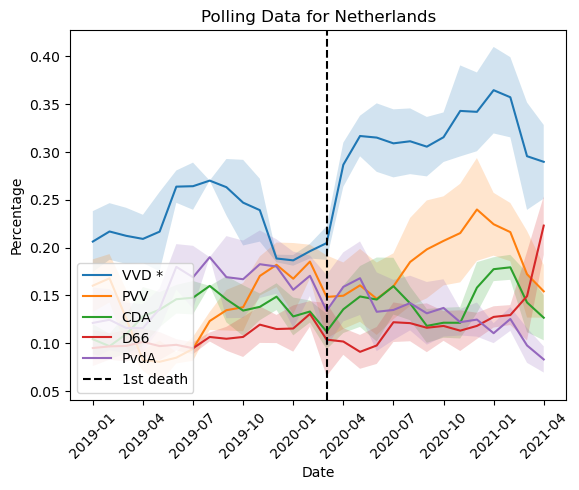

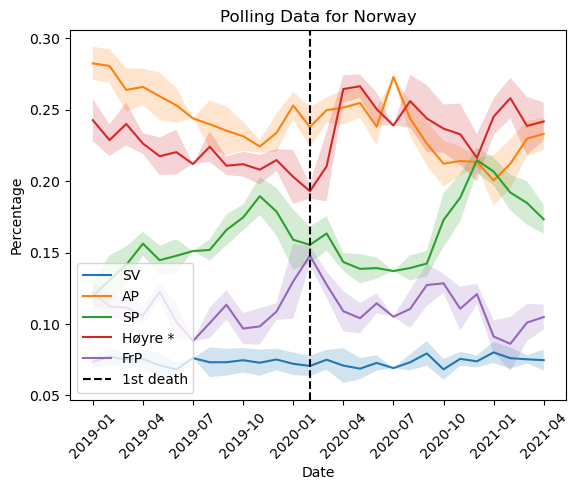

In [10]:
dfs_group2 = []

for country in response_groups[1]:
    df = get_polling_data(country)
    dfs_group2.append(df)
    plot_polling_data(df, country, df_dates)

In contrast, countries in group 2 (smaller countries where the government reacted quickly) all observed sudden sharp increases in support for the government. In the case of Norway, the ruling party's steady decrease in popularity was almost entirely negated. This suggests that the populations greatly valued stability and the quick response of their governments.


In [ ]:
plot_group_alignments(dfs_group2, response_groups[1], df_dates, 'Group 2')

### Group 3

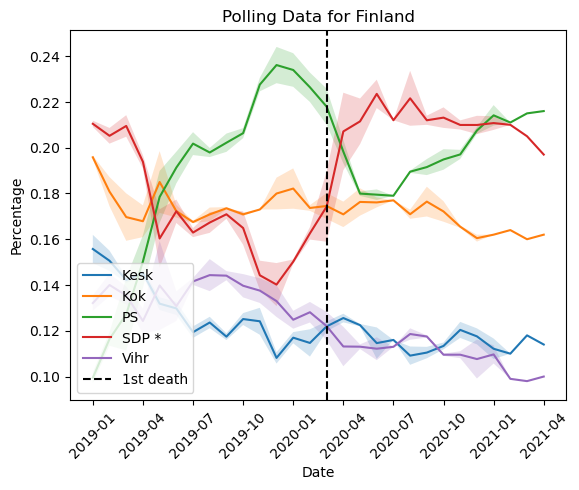

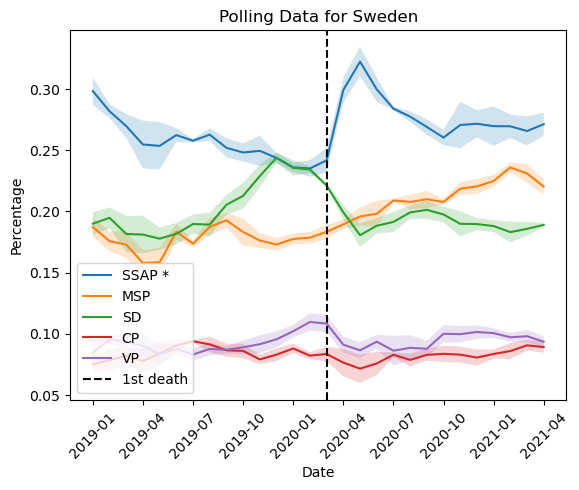

In [11]:
for country in response_groups[2]:
    df = get_polling_data(country)
    plot_polling_data(df, country, df_dates)

In group 3, we observe a similar effect whereby support in the government increases.

It is clear that among the large economies, support in the government did not increase at the start of the pandemic. However, this could be the case for small European countries. To gather evidence to support this hypothesis, we perform t-tests to see if there are statistically significant differences in the polling of ruling parties immediately before and after the beginning of the pandemic in the smaller countries. We take our significance level to be 0.05, although this will need to be corrected to take into account multiple hypothesis testing.

In [12]:
# Significance level
alpha = 0.05

# Number of hypothesis tests
num_tests = len(response_groups[1] + response_groups[2])

# Šidák correction for multiple hypothesis testing
alpha = 1 - (1 - alpha) ** (1 / num_tests)

print(f"Corrected significance level: {alpha:.3f}")

# Perform test for each country
for country in response_groups[1] + response_groups[2]:
    # Calculate p-value
    p_val = polling_data_ttest(country, df_dates)
    # Determine statistical significance
    significant = "significant" if p_val < alpha else "insignificant"
    print(f"{countries[country]} - {p_val:.5f} ({significant})")

Corrected significance level: 0.010
Denmark - 0.00002 (significant)
Netherlands - 0.00212 (significant)
Norway - 0.00294 (significant)
Finland - 0.00017 (significant)
Sweden - 0.00023 (significant)


We see that, even after our correction to take into account the multiple hypothesis testing problem, each of our tests have shown there to be a statistically significant difference in the polling of the main ruling party in the period immediately before and after the start of the pandemic. We, therefore, can reject the null hypothesis that there is no such difference.

We can conclude that in countries with smaller populations, governments saw an increase in support. In these such countries, perhaps the well-being of the population plays a more significant role when it comes to support in the government. We do not observe this in countries with large populations, possibly due to the population believing that keeping the economy open is more important.

## Interest in COVID and Politics

We obtain pageviews of various topics on Wikipedia over time from the Coronawiki dataset. In particular, we are interested in how interest in COVID and in politics evolved over the course of the pandemic. We guage interest by seeing how many pageviews these topics accrue and observe how different stages of the pandemic affected it. As the relevance of COVID grew exponentially in the beginning stages of the pandemic, we plot the pageviews for COVID related on a log-scale, so that we can see when the quick growth in interest started.

In [13]:
# Load data
df_pageviews = pd.read_json(DATA_PATH + "aggregated_timeseries.json.gz")

### Group 1

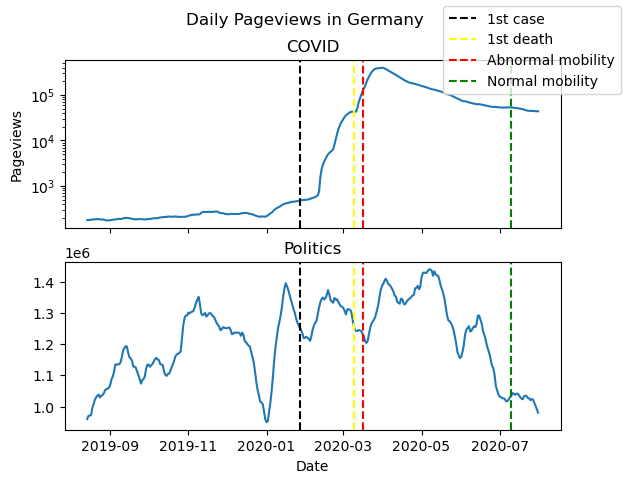

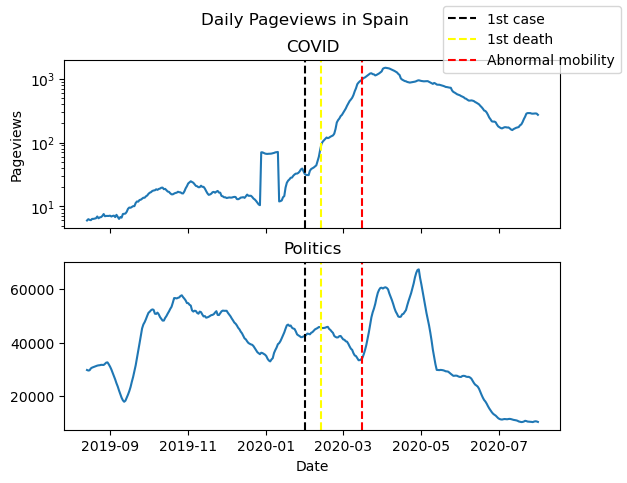

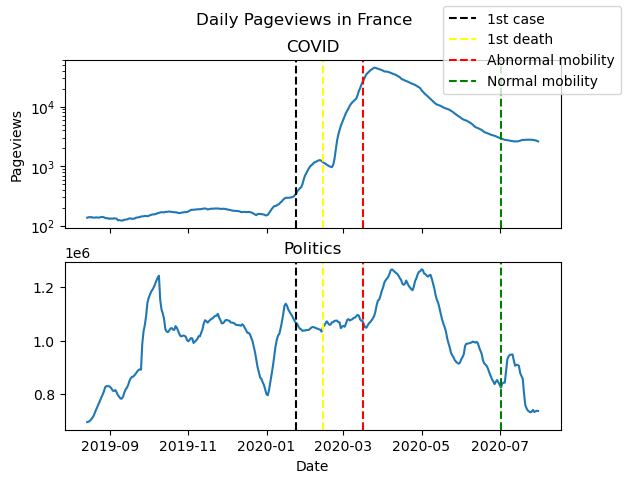

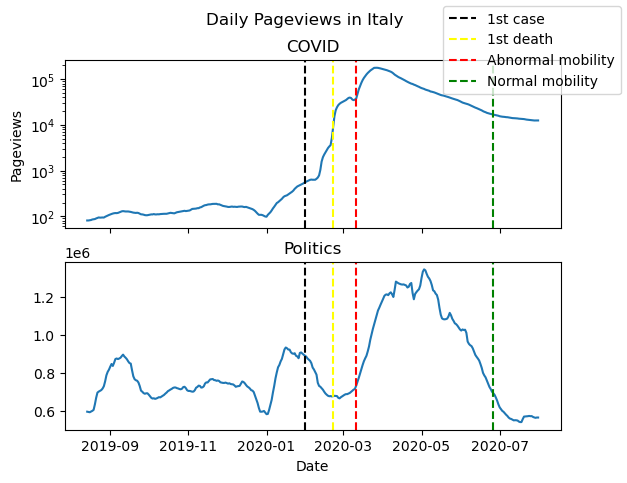

In [14]:
for country in response_groups[0]:
    plot_pageviews2(df_pageviews, country, df_dates)

For the major European countries, we see that the growth in interest in COVID seems to happen around the time the first case of COVID was discovered in the country. We also note that the graph is steepest at the time of the first death or soon after, indicating that the first news of mortality was an instigator for the growth in interest. We observe the peak in interest in COVID in all four countries shortly after the beginning of abnormal mobility. This coincides with when many more people became individually affected by COVID - the implementation of lockdowns and other strict sanitary measures. When people started becoming affected by COVID and having to adapt to a new way of life, interest in COVID in these countries peaked.

There appears to be no direct effect on the interest in politics when COVID first appeared in these countries. This is reasonable as at this point, the situation was being monitored but not acted upon. However, we see rises in interest in politics right when mobility becomes abnormal which coincides with when major decisions had been taken by governments to impose measures on the population. In addition, as people's mobility became affected, people had more time to read up on politics, so this phase of the pandemic marked an increase in political interest and awareness.

### Group 2

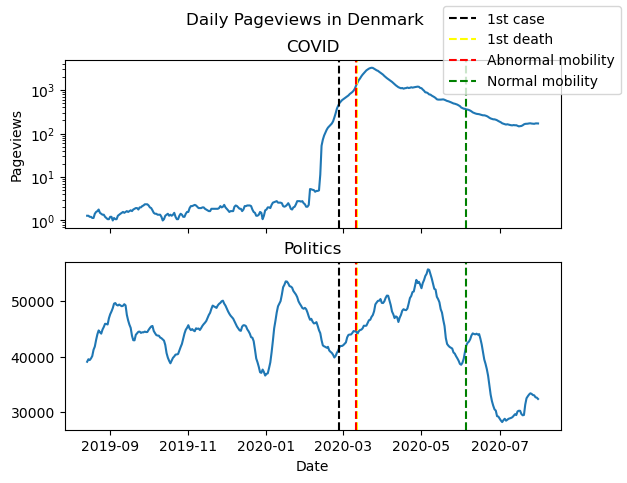

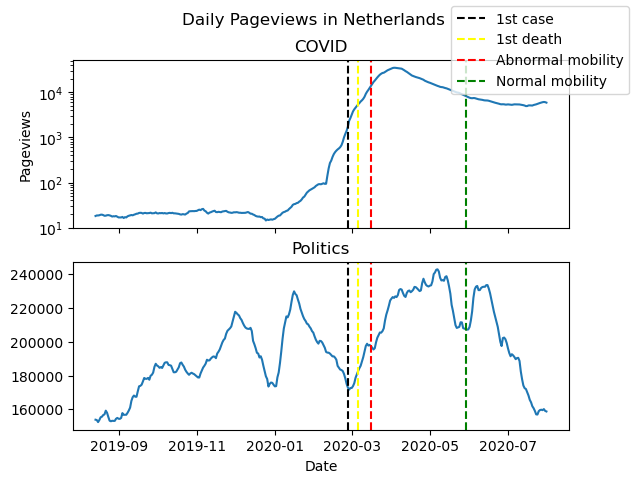

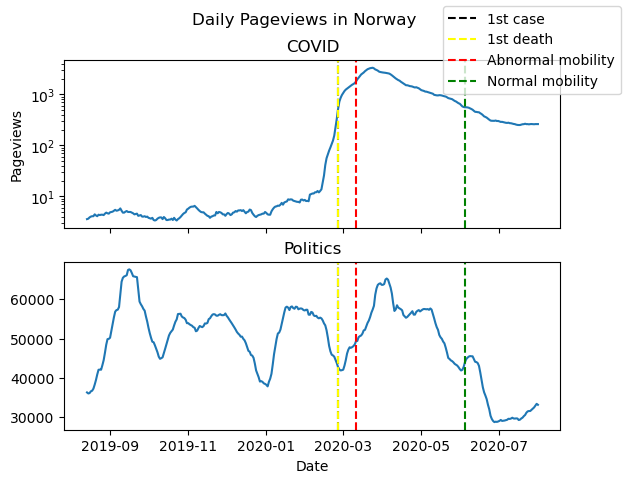

In [15]:
for country in response_groups[1]:
    plot_pageviews2(df_pageviews, country, df_dates)

The smaller European countries which reacted quickly to COVID followed a different trend with regards to interest in COVID. We see the start of the explosive rise in interest happening before there were even any cases of COVID in the country, which could be due to the fact that these countries were already closely observing how the situation was evolving in the major European countries. The populations were already interested/concerned about COVID before it appeared in their country, hence governments would react quickly to address their citizens' concerns.

These countries also exhibited similar trends with regards to the interest in politics. The first cases correspond with the beginning of the rise in interest in politics in these countries. Unlike in the group 1 countries, interest in politics was rising before mobility became abnormal, meaning that the increased pageviews are due to increased interest and not due to the population being locked down and having more spare time. Also unlike in group 1 countries, we observe interest in politics falling soon after mobility returning to normal.

### Group 3

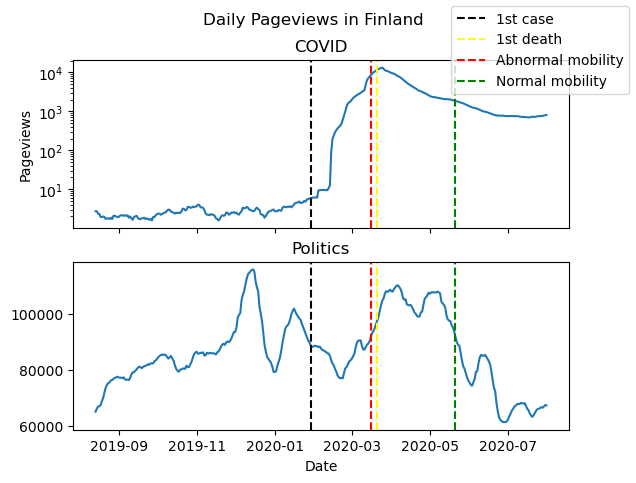

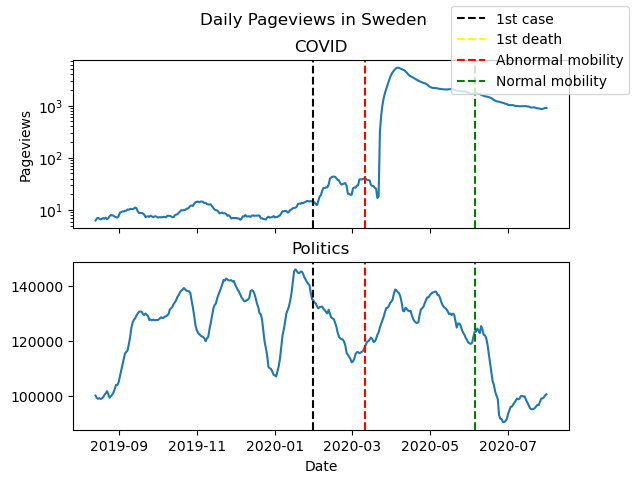

In [16]:
for country in response_groups[2]:
    plot_pageviews2(df_pageviews, country, df_dates)

The countries in group 3 saw measures being implemented relatively late after the arrival of COVID in the country. Unlike the countries in the other two groups, the exponential growth in the interest in COVID had not yet begun when the first cases were discovered. The explosion occured roughly a week later in Finland, but in Sweden this shockingly happened roughly a month later, and only once mobility had started to become affected. Sweden infamously had very lax restrictions in the beginning of the pandemic, and it seems that interest in COVID initially did not explode as a result - people only became interested in COVID when restrictions started to affect their lives.

The arrival of COVID did not seem to affect the interest in politics, even if some people may have objected to their government's slow response. However, the populations in these countries were overall pleased with the initial response as the ruling parties saw sharp increases in their popularity. Interest in politics was rising as measures were being put into place and mobility became affected, and we see interest in politics starting to quickly fall once mobility returned to normal.

## Analysing Mobility Data

We can also plot the mobility data with the intervention dates overlayed. This will allow us to see how populations reacted to the pandemic (i.e. did mobility decrease only once governments imposed mobility restrictions, or did people preemptively reduce their own mobility). Alongside the polling data, this could potentially allow us to deduce whether populations had trust in their government. For instance, if government support was high and mobility was reduced before restrictions were imposed (i.e. when governments issued guidance), then it can suggest a high level of trust in the government.

In [17]:
# Loading data
df_transport = pd.read_csv(DATA_PATH + "applemobilitytrends-2020-04-20.csv.gz")
# Processing data
df_transport = process_transport_data(df_transport)

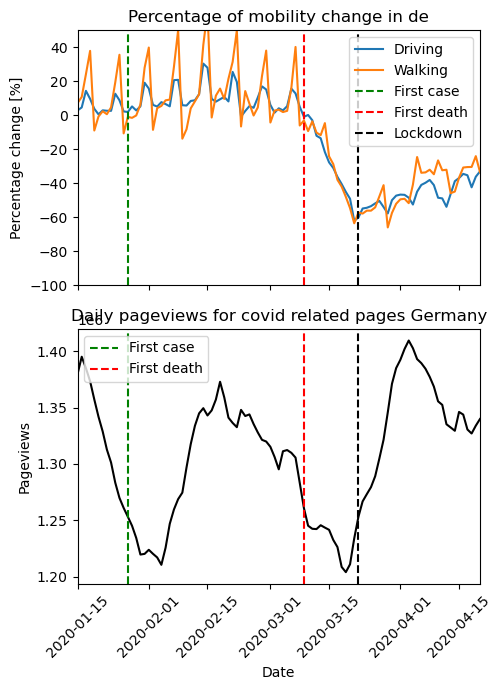

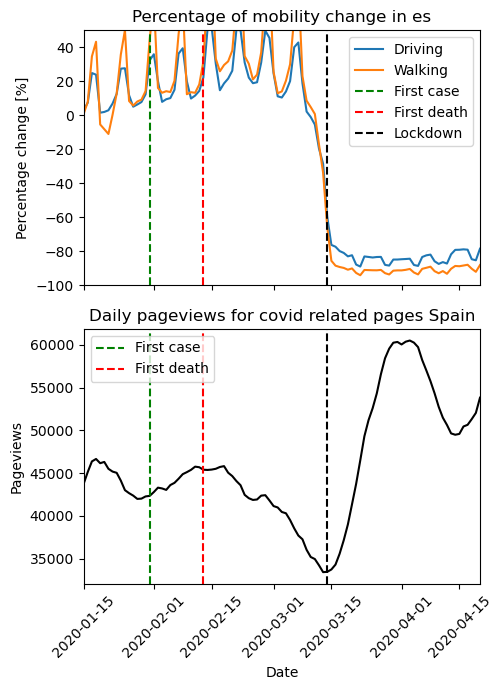

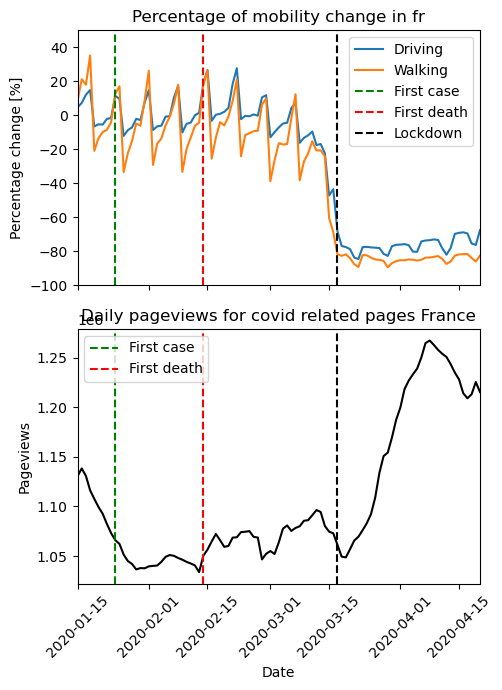

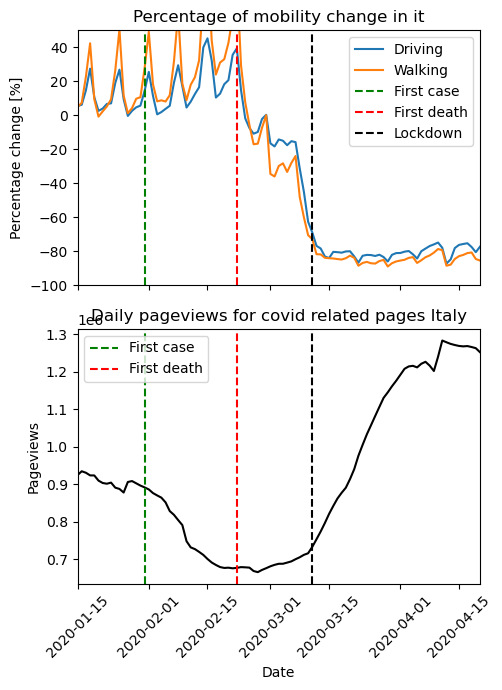

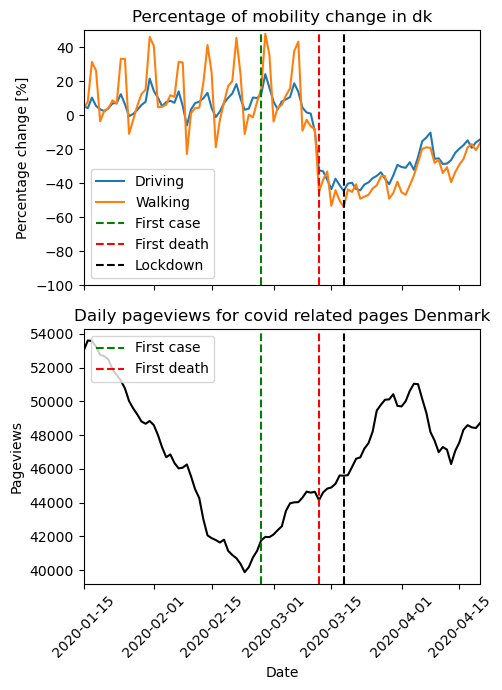

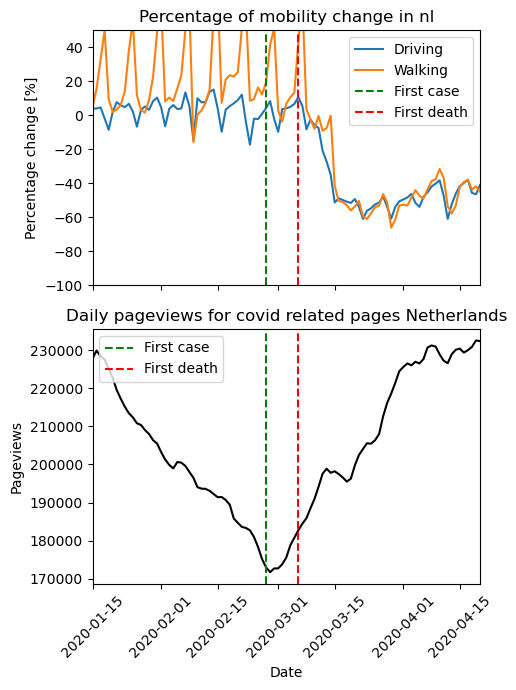

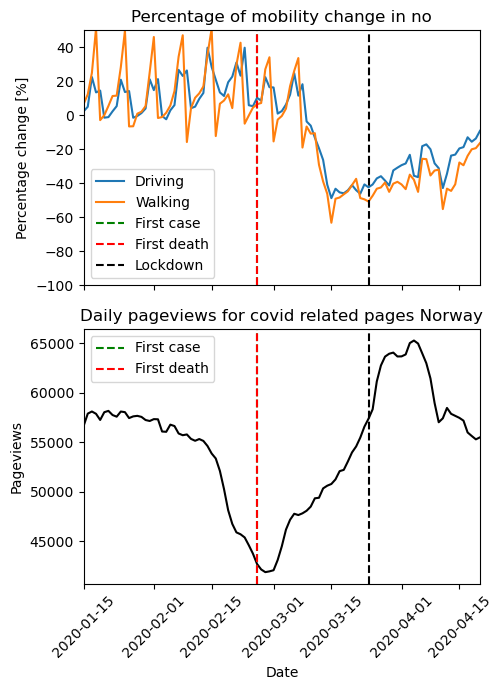

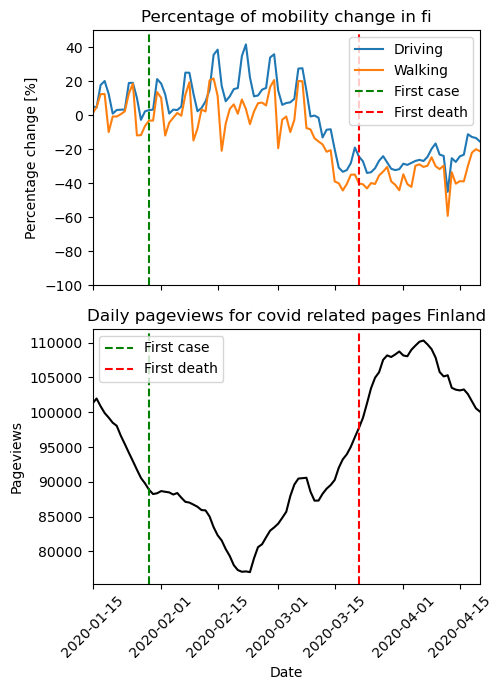

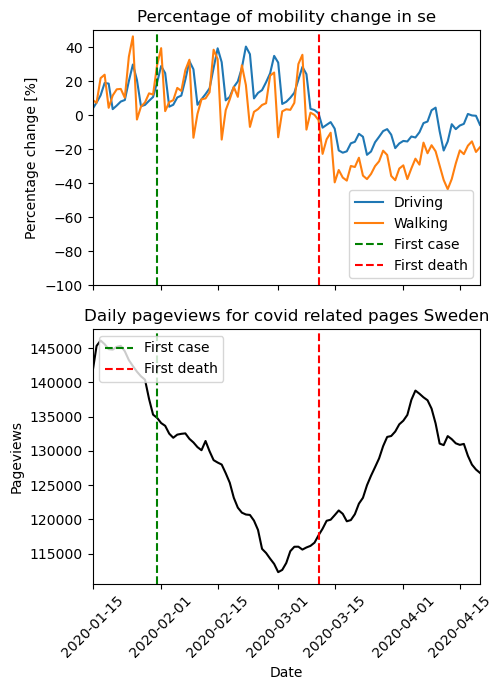

In [18]:
for group in response_groups:
    for country in group:
        df = get_pageviews(df_pageviews, languages[country], POLITICS)
        plot_mobility_pageviews_covid(df_transport, df, country, df_dates)

The mobility data reveals an influence between the governments of European countries managing the crisis on as well as their people in terms of reduced mobility. The way European governments and populations responded to the COVID-19 crisis had a noticeable impact on mobility behaviour. When the first deaths from COVID-19 occurred in countries such as France, Spain, and Norway, there was little change in mobility. This may be because COVID-19 was still relatively unknown in Europe then. However, as the virus spread more widely and began causing more deaths, particularly in countries like Italy, the interest in COVID-19 increased, and this was reflected in the evolution of COVID-related pageviews over time. In Germany, Italy, Netherlands, and Sweden, the first deaths were accompanied by a reduction in mobility and an increase in interest in COVID-19. In Denmark and Finland, where the first deaths occurred later and events had already influenced the interest in COVID-19 in other countries, the reduction in mobility was likely explained by the increased interest in the virus.

In terms of what governments did regarding mobility behaviour, lockdown measures were often implemented once the decline in mobility had stabilised. This suggests that the government's restrictions on mobility came after the population had already decided to reduce their mobility. This may reflect a need for governments to be more responsive to the needs and concerns of their citizens. It is also possible that these actions have impacted political opinion, as different populations may have had varying reactions to the measures taken to address the COVID-19 crisis. Let's then see how does political opinion changes during this period of time.